In [34]:
using Bridge # needs master
using StaticArrays
SV = SVector{3,Float64} # A point in 3 dimensions
SM = SMatrix{3,3,Float64,9}; # A 3x3 linear transformation

In [35]:
using Luxor, Colors

In [36]:
srand(1234);

In [37]:
# centers of each of the three vortices (physically correct: whirlpool)
z1, z2, z3 = zz = [SV(0,0,0), SV(-1,-1/sqrt(3),0), SV(-1, 1/sqrt(3), 0)]

# x, y - space coordinates
# z - age coordinate

# drift acts on age (dots get older)
β = SV(0, 0, 0.5)

# mean reversion matrix (real eigenvalues correspond to forces of attraction, 
# complex eigenvalues to rotational forces)
B = SM([-0.2  1   0 
        -1   -0.2 0 
         0    0   0]);




In [38]:
# according to age, points are attracted to different vortices
b(t, x) = B*(x - (x[3]<10)*z1 - (10<x[3]<20)*z2 - (20< x[3]<30)*z3) + β

b (generic function with 1 method)

In [39]:
# time axis
tt = collect(0:0.01:60); length(tt)

6001

In [40]:
# starting point in third vortex
u = z3

3-element SVector{3,Float64}:
 -1.0    
  0.57735
  0.0    

In [41]:
# allocate space for solution `U` (both time axis and locations)
U = SamplePath(tt, zeros(SV, length(tt)))

# solve dynamical system with derivative `b`, start in `u` and third order method BS3
solve!(Bridge.BS3(), U, u, b)

(Bridge.SamplePath{SVector{3,Float64}}([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  59.91, 59.92, 59.93, 59.94, 59.95, 59.96, 59.97, 59.98, 59.99, 60.0], SVector{3,Float64}[[-1.0, 0.57735, 0.0], [-0.99219, 0.586148, 0.005], [-0.984309, 0.594849, 0.01], [-0.976356, 0.603454, 0.015], [-0.968335, 0.611962, 0.02], [-0.960244, 0.620373, 0.025], [-0.952086, 0.628686, 0.03], [-0.943862, 0.6369, 0.035], [-0.935573, 0.645015, 0.04], [-0.92722, 0.653031, 0.045]  …  [-1.01878, 0.566425, 29.955], [-1.01885, 0.566634, 29.96], [-1.01892, 0.566845, 29.965], [-1.01899, 0.567055, 29.97], [-1.01905, 0.567265, 29.975], [-1.01911, 0.567476, 29.98], [-1.01917, 0.567687, 29.985], [-1.01923, 0.567898, 29.99], [-1.01928, 0.56811, 29.995], [-1.01934, 0.568321, 30.0]]), 0.006184038207458661)

In [42]:
# color points according to age
function colorf(x,y,z) 
    j = 10<z<20 ? 2 : 20< z< 30 ? 3 : 1
    [colorant"brown3", colorant"forestgreen", colorant"mediumorchid3"][j]
end    

colorf (generic function with 1 method)

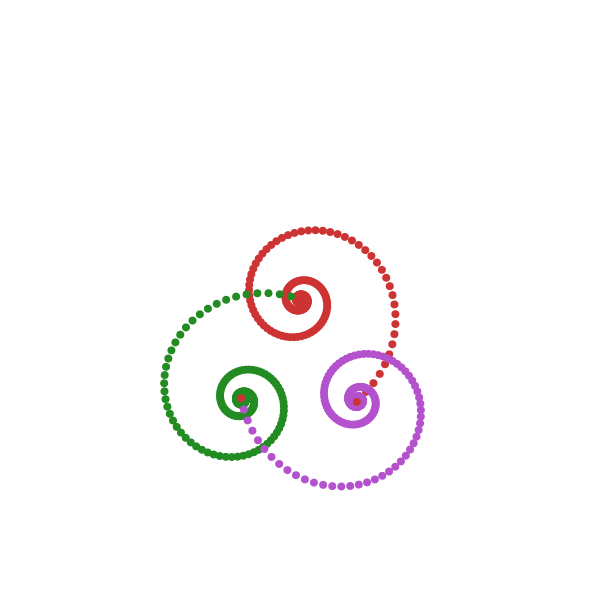

In [43]:
# show the solution
@svg begin
    for p in U.yy[1:10:end]
        (x,y,z) = p
        g = Point(100y,-100x) 
        sethue(colorf(x,y,z))
        circle(g, 4, :fill)
    end    
end

In [44]:
# Define stochastic differential equation
#
# Dynamical system with diffusivity corresponding to additive 
# Gaussian noise with variance '(0.1)^2' per unit time and dynamics 'b'
struct LogoP <: ContinuousTimeProcess{SV}
end
Bridge.b(s, x, ::LogoP) = b(s, x) # drift
Bridge.σ(s, x, ::LogoP) = 0.1I
Bridge.a(s, x, ::LogoP) = 0.1*0.1*I # diffusivity



In [45]:
# allocate path of solution
X = copy(U);

In [46]:
# solve the stochastic differential equation with `EulerMaruyama`
solve!(Bridge.EulerMaruyama(), X, u, sample(tt, Wiener{SV}()), LogoP() );

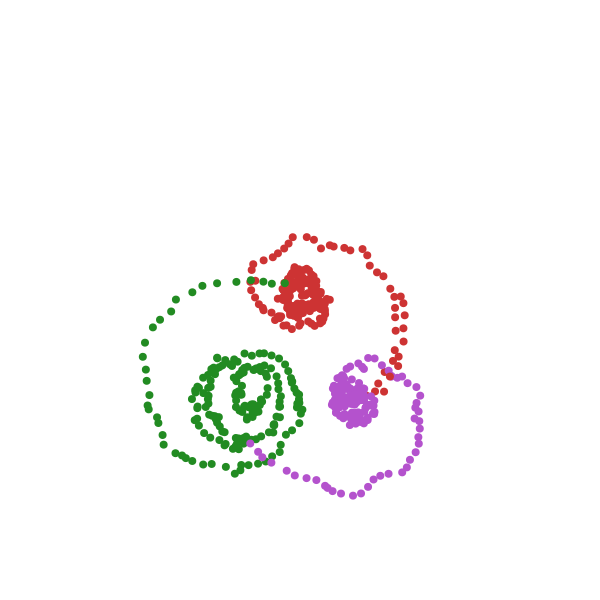

In [47]:
# Plot `X`. Note the randomness
@svg begin
    for p in X.yy[1:10:end]
        (x,y,z) = p
        g = Point(100y,-100x) 
        sethue(colorf(x,y,z))
        circle(g, 4, :fill)
    end    
end

In [48]:
# Define a linear approximation to the stochastic differential equation
struct LogoAppr <: ContinuousTimeProcess{SV}
    t0 # starting time
    z0 # starting age
end
b2(t, x) = B*x + Bridge.β(t, LogoAppr(0.0, u[3])) 
Bridge.B(t, ::LogoAppr) = B

# age (which growth randomly) substituted by deterministic time make
# the system linear
function Bridge.β(t, P::LogoAppr) 
    z = P.z0 + (t - P.t0)*β[3]
    B*( - (z<10)*z1 - (10<z<20)*z2 - (20< z <30)*z3) + β
end

# same diffusivity
Bridge.a(t, ::LogoAppr) = Bridge.a(t, u, LogoP()) 

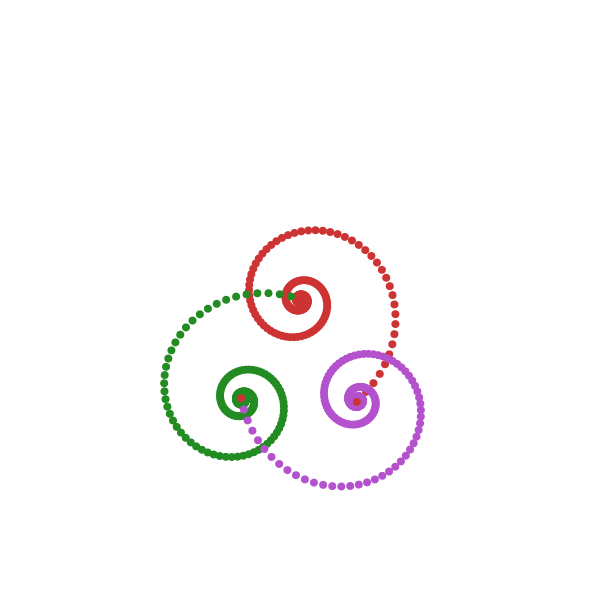

In [49]:
# Without noise age growths deterministically and LogoAppr has the same 
# dynamics as LogoP

U2 = SamplePath(tt, zeros(SV, length(tt)));
solve!(Bridge.BS3(), U2, u, b2)
@svg begin
    for p in U2.yy[1:10:end]
        (x,y,z) = p
        g = Point(100y,-100x) 
        sethue(colorf(x,y,z))
        circle(g, 4, :fill)
    end    
end

In [50]:
# pick some time span for animation
n0 = 100
 m = 59
nend = n0 + m - 1
frames = n0:nend;

In [51]:
m2 = 20 # subsampling factor

# now we define the time axis of the animation
tt2 = collect(linspace(tt[n0], tt[nend], m*m2));

In [52]:
# number of particles
K = 1000

# reserve space
XX0 = [SamplePath(tt[1:n0], zeros(SV, length(tt[1:n0]))) for k in 1:K];
XX = [SamplePath(tt2, zeros(SV, length(tt2))) for k in 1:K];


In [53]:
# evolve XX0 starting in U for n0*dt steps (randomizes U somewhat)
for k in 1:K
    solve!(Bridge.EulerMaruyama(), XX0[k], U.yy[length(tt)÷K*k], sample(tt[1:n0], Wiener{SV}()), LogoP() )
end
# take positions of particles at end-time of `XX0` as starting points of `XX` 
us = [XX0[k].yy[end] for k in 1:K] 
for k in 1:K
    # CONSTRAINED/CONDITIONAL stochastic differential equation: particle `k` moves to starting position of particle `k + 11`
    # Why 11? the particle `k+11` is on average as old now as the particle `k` will be at the end of `tt2`
    GP = Bridge.GuidedBridge(tt2, (us[k], us[mod1(k+11,K)]), LogoP(), LogoAppr(tt2[1], us[k][3]))
    
    # solve the CONSTRAINED/CONDITIONAL stochastic differential equation
    Bridge.bridge!(Bridge.EulerMaruyama(), XX[k], sample(tt2, Wiener{SV}()), GP)
end

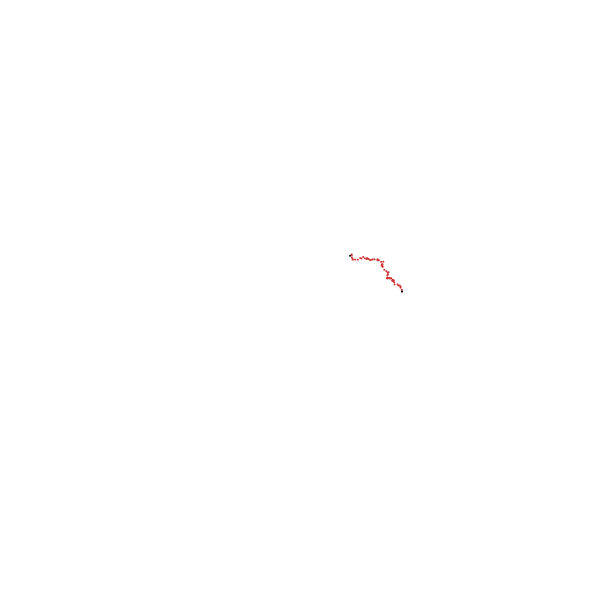

In [54]:
# a path looks is constrained to start in us[k] and end in us[k+1]
k = 3; GP = Bridge.GuidedBridge(tt2, (XX0[k].yy[1], XX0[mod1(k+11,K)].yy[1]), LogoP(), LogoAppr(tt2[1], XX0[k].yy[1][3]))
GP.tt;
@svg begin
    for p in XX[k].yy[1:m2:end]
        (x,y,z) = p
        g = Point(100y,-100x) 
        sethue(colorf(x,y,z))
        circle(g, 1, :fill)
    end    
    sethue(colorant"black")
    for p in [us[k], us[mod1(k+11,K)]]
        (x,y,z) = p
        g = Point(100y,-100x) 
        circle(g, 1, :fill)
    end
end

In [55]:
# define movie frame
function frame(szene, i)
    for k in 1:K
        x, y, z = XX[k].yy[1 + (i-1)*m2] #subsample
        g = Point(50y,-35-50x) 
        sethue(colorf(x,y,z))
        circle(g, 2, :fill)
    end
end


frame (generic function with 1 method)

In [56]:
# build movie
bang = Movie(350÷2, 350÷2, "test", 1:m)


Luxor.Movie(175.0, 175.0, "test", 1:59)

In [57]:
backdrop(scene, framenumber) =  background("white")

backdrop (generic function with 1 method)

In [59]:
# create movie: see output for gif location
animate(bang, [Scene(bang, backdrop, 1:m), Scene(bang, frame, 1:m)], framerate=10, creategif = true, pathname="/tmp/animationtest.gif")


INFO: Frames for animation "test" are being stored in directory: 
	 /var/folders/zm/_k619j950rgcj72mlr4phfgjyj_8r5/T/tmpDWK8f1
INFO: ... 59 frames saved in directory:
	 /var/folders/zm/_k619j950rgcj72mlr4phfgjyj_8r5/T/tmpDWK8f1
INFO: GIF is: /tmp/animationtest.gif


true